### Task 6: Predictive Modeling – Linear Regression

#### Step 1: Load Data

##### We need two datasets:

1. test_with_sentiment.csv : contains individual emails with sentiment labels and scores

2. employee_monthly_sentiment_scores.csv : contains monthly sentiment scores per employee

In [1]:
import pandas as pd

# Load sentiment-labeled email data
df_emails = pd.read_csv("test_with_sentiment.csv")
df_emails['date'] = pd.to_datetime(df_emails['date'], errors='coerce')
df_emails['year_month'] = df_emails['date'].dt.to_period('M')

# Load monthly sentiment scores (target variable)
df_monthly = pd.read_csv("employee_monthly_sentiment_scores.csv")


#### Step 2: Create Features

##### We want features that may influence sentiment:

1. Number of messages per month
2. Number of positive, negative, and neutral messages
3. Average message length (characters)
4. Average word count per message

In [2]:
# Map sentiment labels to numeric scores
sentiment_score_map = {
    "Positive": 1,
    "Negative": -1,
    "Neutral": 0
}

df_emails['sentiment_score'] = df_emails['sentiment_label'].map(sentiment_score_map)


In [3]:
# Add message length and word count
df_emails['message_length'] = df_emails['body'].str.len()
df_emails['word_count'] = df_emails['body'].str.split().apply(len)

# Aggregate features per employee-month
features = df_emails.groupby(['from', 'year_month']).agg(
    num_messages=('body', 'count'),
    num_positive=('sentiment_score', lambda x: (x==1).sum()),
    num_negative=('sentiment_score', lambda x: (x==-1).sum()),
    num_neutral=('sentiment_score', lambda x: (x==0).sum()),
    avg_message_length=('message_length', 'mean'),
    avg_word_count=('word_count', 'mean')
).reset_index()


#### Step 3: Merge Features with Target

In [4]:
# Aggregate features per employee-month
features = df_emails.groupby(['from', 'year_month']).agg(
    num_messages=('body', 'count'),
    num_positive=('sentiment_score', lambda x: (x==1).sum()),
    num_negative=('sentiment_score', lambda x: (x==-1).sum()),
    num_neutral=('sentiment_score', lambda x: (x==0).sum()),
    avg_message_length=('body', lambda x: x.str.len().mean()),
    avg_word_count=('body', lambda x: x.str.split().apply(len).mean())
).reset_index()

# Convert 'year_month' to string so it matches df_monthly
features['year_month'] = features['year_month'].astype(str)
df_monthly['year_month'] = df_monthly['year_month'].astype(str)

# Now merge features with monthly sentiment scores
data = pd.merge(
    features, 
    df_monthly, 
    on=['from', 'year_month'], 
    how='left'
)


#### Step 4: Split Data into Train and Test

In [5]:
# Define independent variables (features)
X = data[['num_messages', 'num_positive', 'num_negative', 'num_neutral', 
          'avg_message_length', 'avg_word_count']]

# Define dependent variable (target)
y = data['monthly_sentiment_score']


In [6]:
from sklearn.model_selection import train_test_split

# Split into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#### Step 5: Train Linear Regression Model

In [7]:
from sklearn.linear_model import LinearRegression

# Initialize and train model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


#### Step 6: Make Predictions and Evaluate

In [8]:
from sklearn.metrics import mean_squared_error, r2_score

# Predict on test set
y_pred = lr_model.predict(X_test)

# Evaluate model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"R-squared (R²): {r2:.3f}")

Mean Squared Error (MSE): 0.000
R-squared (R²): 1.000


#### Step 7: Interpret Coefficients

In [9]:
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_
})

print(coefficients)

              Feature   Coefficient
0        num_messages -2.481237e-16
1        num_positive  1.000000e+00
2        num_negative -1.000000e+00
3         num_neutral  8.743006e-16
4  avg_message_length  0.000000e+00
5      avg_word_count -8.326673e-16


#### Step 8: Optional Visualization

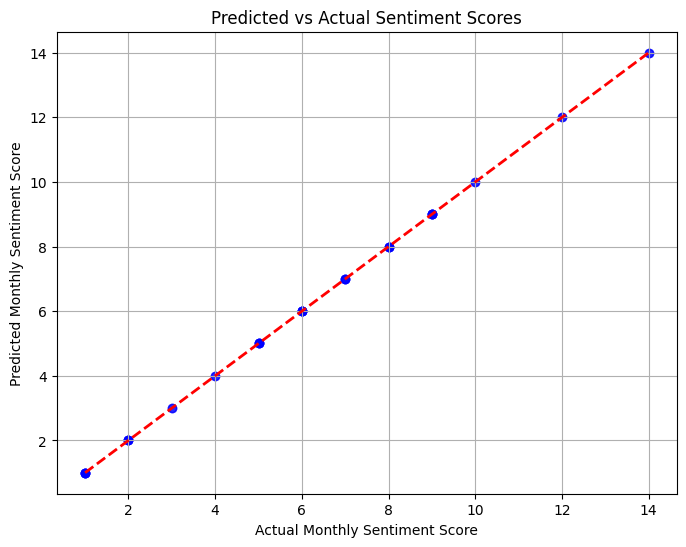

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Actual Monthly Sentiment Score')
plt.ylabel('Predicted Monthly Sentiment Score')
plt.title('Predicted vs Actual Sentiment Scores')
plt.grid(True)
plt.show()


C:\Users\ACER\AppData\Local\Temp\ipykernel_18380\3131525533.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coefficients, palette='coolwarm')


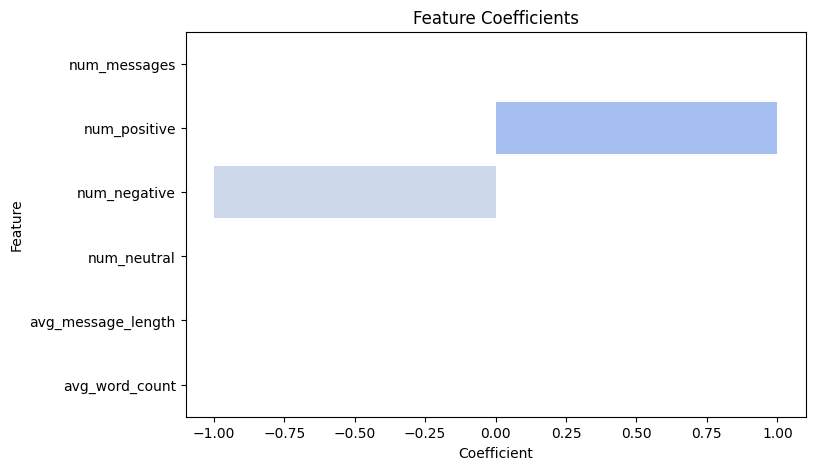

In [13]:
import seaborn as sns
import pandas as pd

coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_
})

plt.figure(figsize=(8,5))
sns.barplot(x='Coefficient', y='Feature', data=coefficients, palette='coolwarm')
plt.title('Feature Coefficients')
plt.show()
